
# Upper Air Sounding Tutorial

Upper air analysis is a staple of many synoptic and mesoscale analysis
problems. In this tutorial we will gather weather balloon data, plot it,
perform a series of thermodynamic calculations, and summarize the results.
To learn more about the Skew-T diagram and its use in weather analysis and
forecasting, checkout [this](http://www.pmarshwx.com/research/manuals/AF_skewt_manual.pdf)
air weather service guide.


In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

## Getting Data

Upper air data can be obtained using the siphon package, but for this tutorial we will use
some of MetPy's sample data. This event is the Veterans Day tornado outbreak in 2002.



In [2]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('nov11_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [3]:
# We will pull the data out of the example dataset into individual variables and
# assign units.

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

## Thermodynamic Calculations

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.



In [4]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

923.1157642313738 hectopascal 15.595751336163403 degree_Celsius


## Basic Skew-T Plotting

The Skew-T (log-P) diagram is the standard way to view rawinsonde data. The
y-axis is height in pressure coordinates and the x-axis is temperature. The
y coordinates are plotted on a logarithmic scale and the x coordinate system
is skewed. An explanation of skew-T interpretation is beyond the scope of this
tutorial, but here we will plot one that can be used for analysis or
publication.

The most basic skew-T can be plotted with only five lines of Python.
These lines perform the following tasks:

1. Create a ``Figure`` object and set the size of the figure.

2. Create a ``SkewT`` object

3. Plot the pressure and temperature (note that the pressure,
   the independent variable, is first even though it is plotted on the y-axis).

4. Plot the pressure and dewpoint temperature.

5. Plot the wind barbs at the appropriate pressure using the u and v wind
   components.



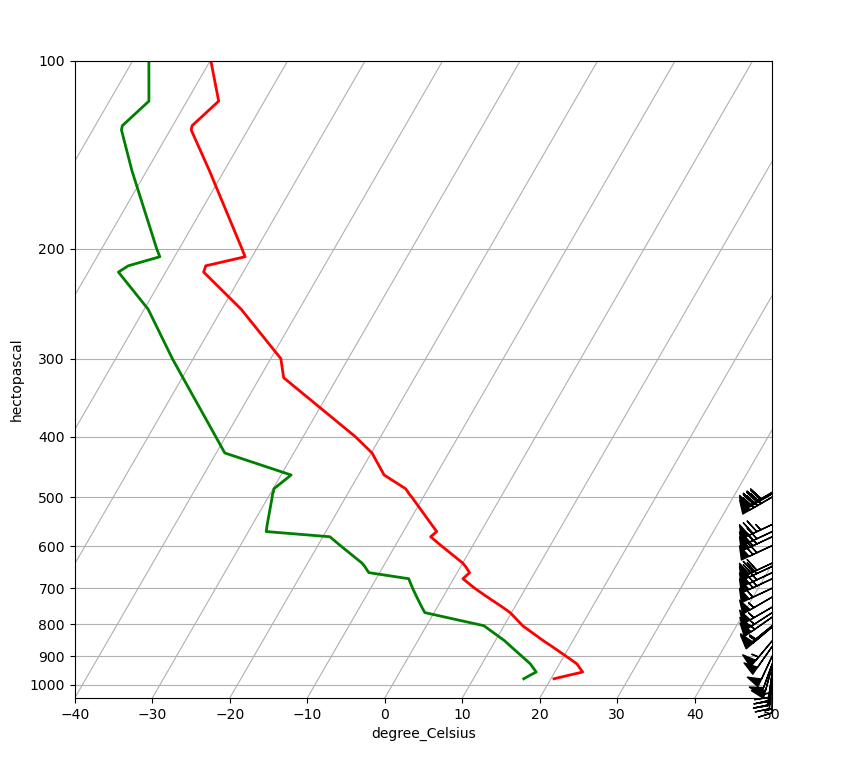

In [5]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.show()

## Advanced Skew-T Plotting

Fiducial lines indicating dry adiabats, moist adiabats, and mixing ratio are
useful when performing further analysis on the Skew-T diagram. Often the
0C isotherm is emphasized and areas of CAPE and CIN are shaded.



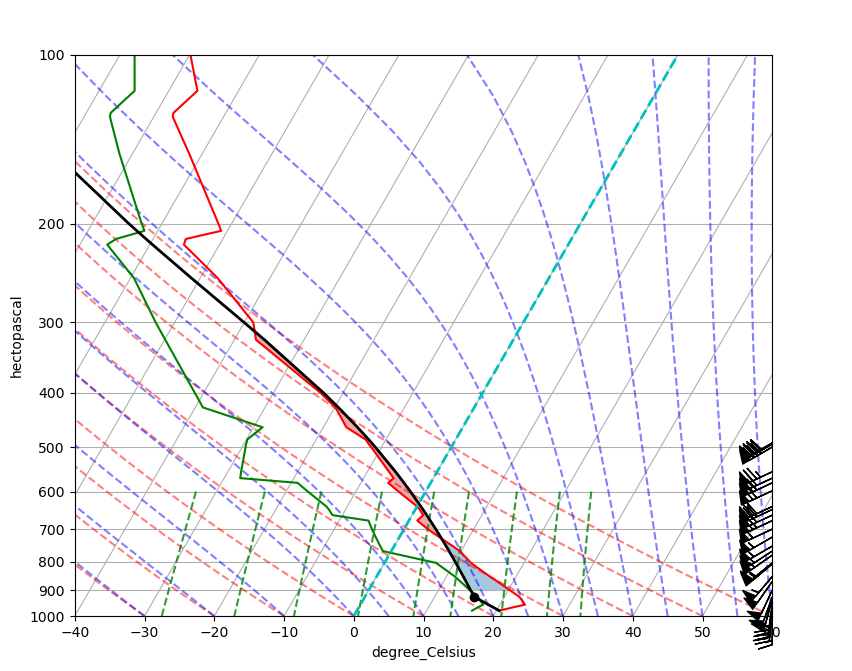

In [9]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

## Adding a Hodograph

A hodograph is a polar representation of the wind profile measured by the rawinsonde.
Winds at different levels are plotted as vectors with their tails at the origin, the angle
from the vertical axes representing the direction, and the length representing the speed.
The line plotted on the hodograph is a line connecting the tips of these vectors,
which are not drawn.



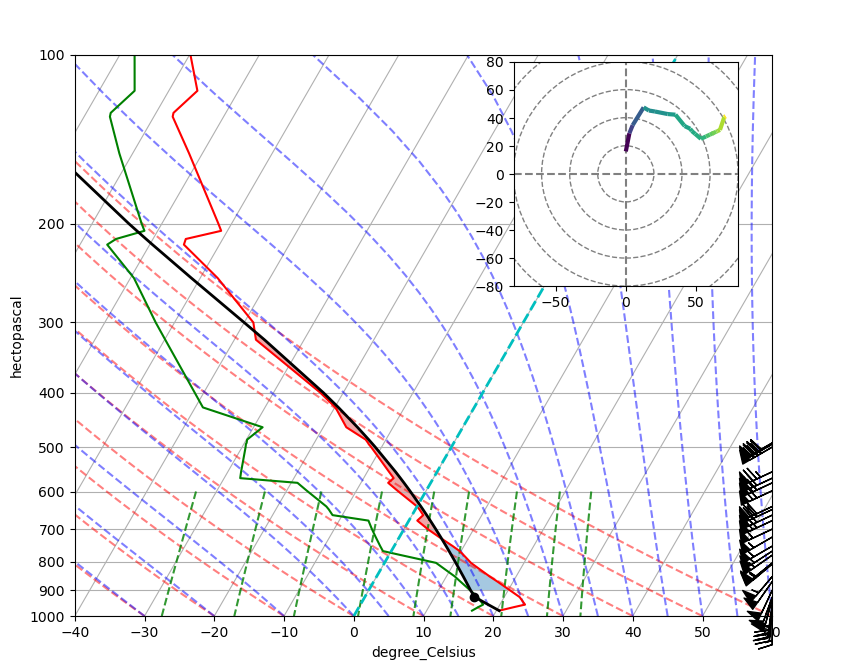

In [10]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.show()